In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = "/Users/rhl/TeX/Talks/DSFP/2018-01/Exercises/Detectors"

Let's start by looking at some extracted spectra

Read the data (and don't worry about the details of how this cell works!).

- The reference lines (a dict `arcLines` indexed by `fiberId` containing numpy arrays):
 - `pixelPos`           Measured centroid of an arc line (pixels)
 - `pixelPosErr`        Error in pixelPos
 - `refWavelength`      Nominal wavelength (from NIST)
 - `modelFitWavelength` Wavelength corresponding to pixelPos, based on instrument model
 - `status`             bitwise OR of flags (see statusFlags)
- A dict `statusFlags` giving the meaning of the status bits
- `wavelength0` and `npPerPix`  A couple of scalers giving an approximate wavelength solution

- The arc spectra (a dict `spectra` indexed by `fiberId` containing numpy arrays):
 - `flux`     The flux level of each pixel
 - `fluxVar`  The error in `flux`
 - `modelFitLambda`  The wavelength at each pixel according to my instrument model
- An array `pixels` giving the pixel values associated with the `wavelengths`, `fluxes`, and `fluxVars` arrays


In [2]:
dataDump = np.load(os.path.join(dataDir, "spectro.npz"))

packed      = dataDump["packed"]
statusFlags = dataDump["statusFlags"].reshape(1)[0]
fiberIds    = dataDump["fiberIds"]
dataFields  = dataDump["dataFields"]
wavelength0 = dataDump["wavelength0"]
nmPerPix    = dataDump["nmPerPix"]
pixels      = dataDump["pixels"]
fluxes      = dataDump["fluxes"]
fluxVars    = dataDump["fluxVars"]
modelFitLambdas = dataDump["modelFitLambdas"]

arcLines = {}
spectra = {}
for i, fiberId in enumerate(fiberIds):
    arcLines[fiberId] = {}
    spectra[fiberId] = {}

    for j, n in enumerate(dataFields):
        arcLines[fiberId][n] = packed[i][j]
    arcLines[fiberId]['status'] = arcLines[fiberId]['status'].astype('int')

    spectra[fiberId]["modelFitLambda"] = modelFitLambdas[i]
    spectra[fiberId]["flux"] = fluxes[i]
    spectra[fiberId]["fluxVar"] = fluxVars[i]
            
del packed; del dataFields
del modelFitLambdas; del fluxes; del fluxVars

Plot the spectrum.  Do the lines from the different fibres line up?

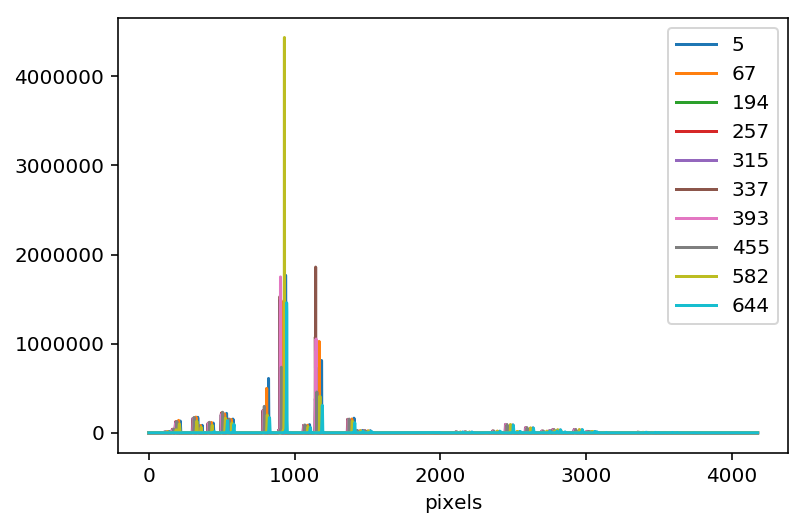

In [3]:
plt.clf()
for fiberId in fiberIds:
    plt.plot(pixels, spectra[fiberId]["flux"], label=str(fiberId))
    
plt.legend()
plt.xlabel("pixels");

I think that the answer is, "No".  That's why we need a wavelength solution!

Fortunately I have measured the positions of the brighter arclines (the dict `arcLines`).  Choose a fibre and plot the measured lines on top of the spectrum.  You should find that I did a good job with the centroiding.

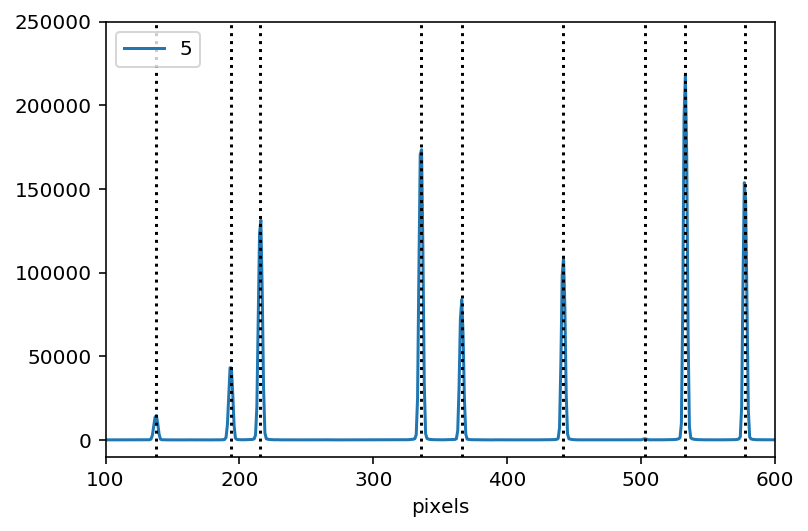

In [4]:
fiberId = 5

plt.clf()
plt.plot(pixels, spectra[fiberId]["flux"], label=str(fiberId))

for p in arcLines[fiberId]["pixelPos"]:
    plt.axvline(p, ls=':', color='black')

plt.xlim(100, 600)
plt.ylim(-1e4, 2.5e5)
plt.legend()
plt.xlabel("pixels");

We have good pixel centroids and we know the true wavelengths, so we can measure our wavelength solution.

Let's concentrate on just one fiber for now; choose a fibre, any fibre.  

Plot some of the fitted lines.  A good place to start would be the pixel position (pixelPos) and the reference wavelength (refWavelength) for a fibre, then use wavelength0 and nmPerPix to construct an approximate (linear) wavelength solution and look at the residuals from the linear fit.

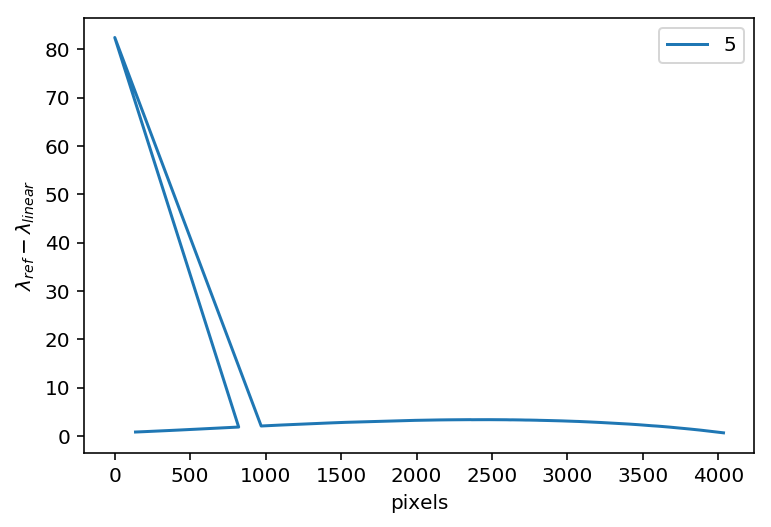

In [5]:
fiberId = 5
assert fiberId in arcLines, "Unknown fiberId: %d" % fiberId
pixelPos = arcLines[fiberId]['pixelPos']
refWavelength = arcLines[fiberId]['refWavelength']

wavelength = wavelength0 + nmPerPix*pixelPos

plt.plot(pixelPos, refWavelength - wavelength, label=str(fiberId))

plt.legend()
plt.xlabel("pixels")
plt.ylabel(r"$\lambda_{ref} - \lambda_{linear}$");

Take a look at the statusFlags and the values of status from your fibre.  You probably want to ignore some of the data. The `FIT` bit is good;  the `SATURATED`, `INTERPOLATED`, and `CR` bits are bad (and the other bits aren't set in this dataset).

Remake your residual plot with the bad lines removed;  is that better?

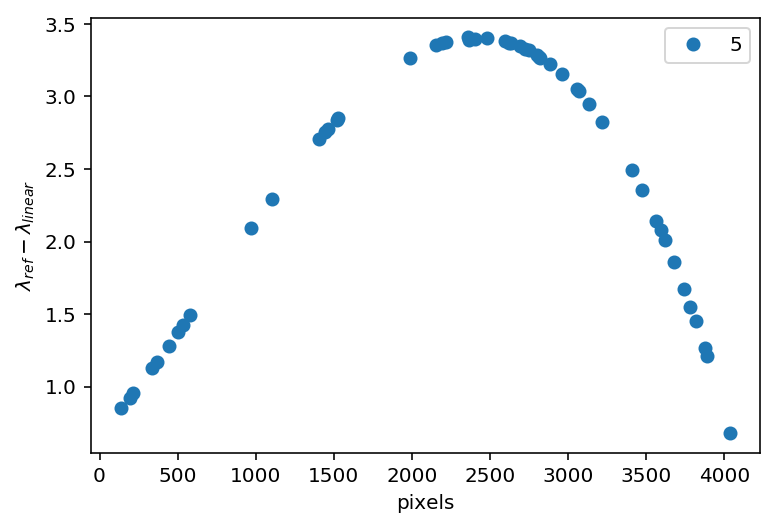

In [6]:
fiberId = 5
assert fiberId in arcLines, "Unknown fiberId: %d" % fiberId
        
pixelPos = arcLines[fiberId]['pixelPos']
refWavelength = arcLines[fiberId]['refWavelength']
status = arcLines[fiberId]["status"]

wavelength = wavelength0 + nmPerPix*pixelPos

good = np.logical_and.reduce([(status & statusFlags["FIT"]) != 0,
                               status & (statusFlags["INTERPOLATED"]) == 0])

plt.plot(pixelPos[good], (refWavelength - wavelength)[good], 'o', label=str(fiberId))

plt.legend()
plt.xlabel("pixels")
plt.ylabel(r"$\lambda_{ref} - \lambda_{linear}$");

Here's the plot for all the fibres:

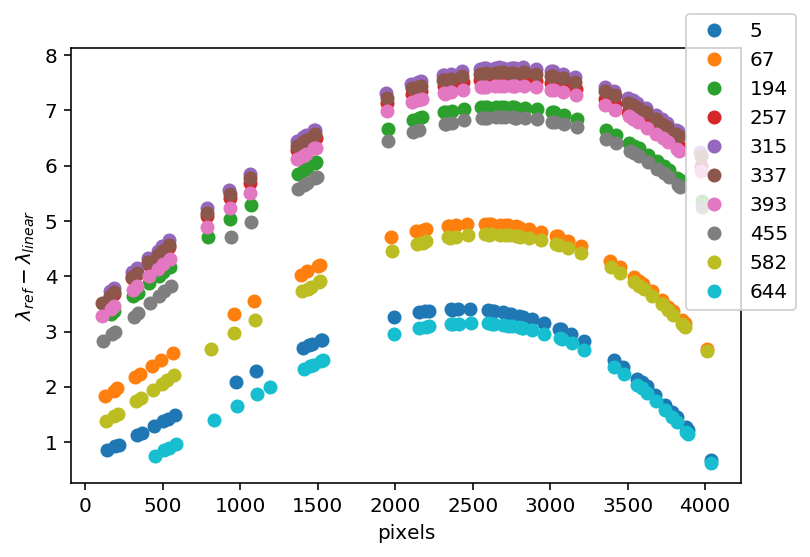

In [7]:
plt.clf()
for fiberId, fiberData in arcLines.items():
    pixelPos = fiberData["pixelPos"]
    pixelPosErr = fiberData["pixelPosErr"]
    refWavelength = fiberData["refWavelength"]
    modelFitWavelength = fiberData["modelFitWavelength"]
    status = fiberData["status"]
    
    wavelength = wavelength0 + nmPerPix*(pixelPos)

    good = np.logical_and.reduce([(status & statusFlags["FIT"]) != 0,
                                   status & (statusFlags["INTERPOLATED"]) == 0])
    
    plt.plot(pixelPos[good], (refWavelength - wavelength)[good], 'o', label=str(fiberId))
    
plt.xlabel("pixels")
plt.ylabel(r"$\lambda_{ref} - \lambda_{linear}$");
plt.legend(loc=9, bbox_to_anchor=(1.0, 1.1));

Fit a curve to those residuals (it's generally better to fit to residuals, especially when you have a more informative model than our current linear one).

Use Chebyshev polynomials;  I recommend using `np.polynomial.chebyshev.Chebyshev.fit`.  You should set the domain of the fit so that it'll be usable over all the CCD's rows.

Experiment with a range of order of fitter, and look at the rms error in the wavelength solution.  You can look at $\chi^2/\nu$ too, if you like, but I think you'll find that the centroiding errors are wrong.

You probably want to look at the fit (to the residuals!) and at the residuals from the fit.

---

This cell answers both this question and the next.  If you set `useLinearApproximation = True` you'll get this solution; if it's `False` you'll do the fit relative to my instrument model.  Note that I'm using different orders for the two fits.

The variable `plotResiduals` controls whether you plot the fit or the residuals.  And note the `if False ...: continue` at the top of the loop; if you change that to `if True ...: continue` or remove it you'll only fit `myFiberId`

I've also added a floor to the centroiding errors.  This is often handy; not only does it allow you to include the systematic errors (quoted errors tend to be only statistical) and thus down-weight points with unrealistically low errors, but it also allows you to perform an unweighted fit by making the floor large enough.

5   rms = 4.17 mpix
67  rms = 4.60 mpix
194 rms = 3.56 mpix
257 rms = 6.63 mpix
315 rms = 5.95 mpix
337 rms = 6.02 mpix
393 rms = 3.92 mpix
455 rms = 4.47 mpix
582 rms = 4.64 mpix
644 rms = 5.21 mpix


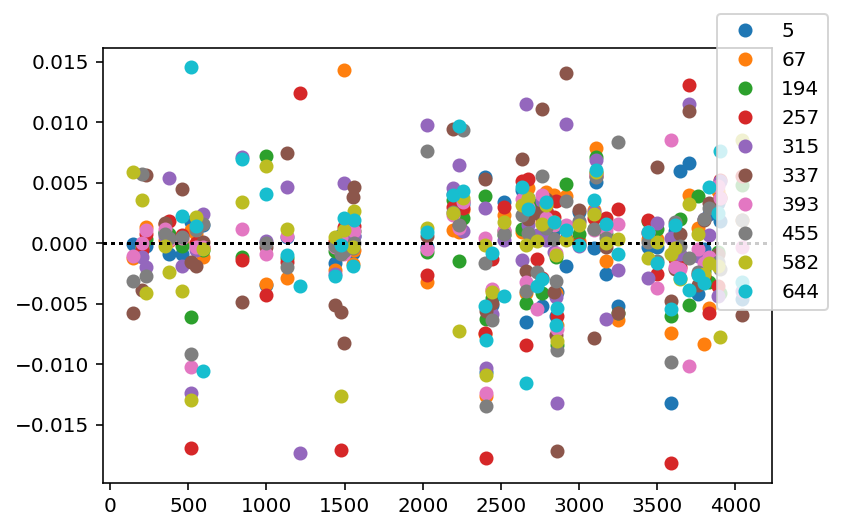

In [8]:
import numpy.polynomial.chebyshev
myFiberId = 315

pixelPosErrorFloor = 0.1

plt.clf()
plotResiduals = True
useLinearApproximation = True

fitOrder = 5 if useLinearApproximation else 2

for fiberId in arcLines:
    if False and fiberId != myFiberId:
        continue

    fiberData = arcLines[fiberId]
    #
    # Unpack data
    #
    pixelPos = fiberData["pixelPos"]
    pixelPosErr = fiberData["pixelPosErr"]
    refWavelength = fiberData["refWavelength"]
    modelFitWavelength = fiberData["modelFitWavelength"]
    status = fiberData["status"]
    
    good = np.logical_and.reduce([(status & statusFlags["FIT"]) != 0,
                                   status & (statusFlags["SATURATED"]) == 0])
    #
    # OK, on to work
    #
    linearWavelength = wavelength0 + nmPerPix*(pixelPos)
    if useLinearApproximation:
        wavelength = linearWavelength
    else:
        wavelength = modelFitWavelength
    
    nominalPixelPos = (refWavelength - wavelength0)/nmPerPix
    fitWavelengthErr = pixelPosErr*nmPerPix

    x = nominalPixelPos[good]
    y = (refWavelength - wavelength)[good]
    yerr = np.hypot(fitWavelengthErr, pixelPosErrorFloor*nmPerPix)[good]
    
    used = np.ones_like(good[good])

    wavelengthCorr = np.polynomial.chebyshev.Chebyshev.fit(
        x[used], y[used], fitOrder, domain=[pixels[0], pixels[-1]], w=1/yerr[used])
    arcLines[fiberId]['wavelengthCorr'] = wavelengthCorr
    yfit = wavelengthCorr(x)

    if plotResiduals:
        plt.plot(x, y - yfit, 'o', label=str(fiberId))
        plt.axhline(0, ls=':', color='black')
    else:
        ax = plt.plot(x, y, 'o', label=str(fiberId))[0]
        plt.plot(pixels, wavelengthCorr(pixels), color=ax.get_color())
    
    print("%-3d rms = %.2f mpix" % 
          (fiberId, 1e3*np.sqrt(np.sum((y - yfit)**2)/(len(y) - fitOrder))))
    
plt.legend(loc=9, bbox_to_anchor=(1.0, 1.1));

Use your wavelength solution to plot the arc spectra against wavelength (you started out by plotting against pixels).
Do the Ne lines for the different fibres agree now?

---

You need to run the previous cell with all fibres for this to work (as that's where we fit the wavelengths)

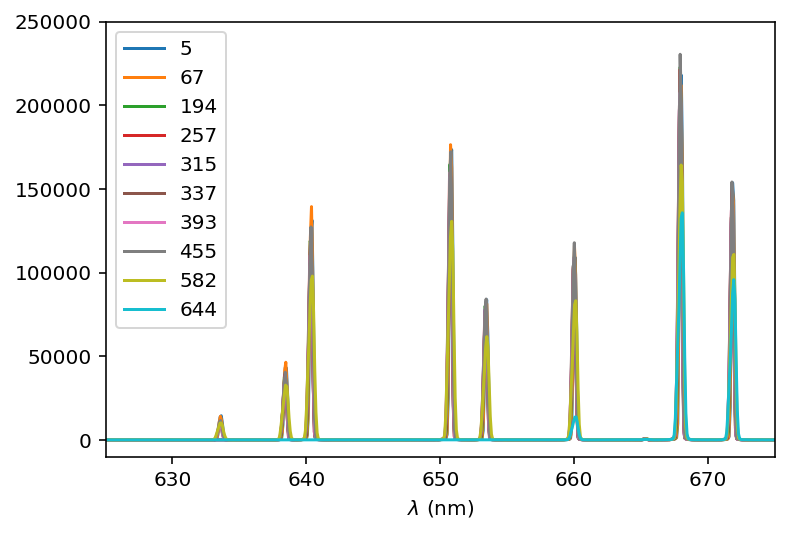

In [9]:
plt.clf()
for fiberId in fiberIds:
    xlab = r"$\lambda$ (nm)"
    if useLinearApproximation:
        x = wavelength0 + nmPerPix*(pixels)
    else:
        x = spectra[fiberId]["modelFitLambda"]

    if 'wavelengthCorr' not in arcLines[fiberId]:   # we didn't process this fibre
        continue
        
    x += arcLines[fiberId]['wavelengthCorr'](pixels)

    plt.plot(x, spectra[fiberId]["flux"], label=str(fiberId))
    
plt.legend()
plt.xlabel(xlab)

if True:
    plt.xlim(625, 675)
    plt.ylim(-10000, 250000)

Now repeat the preceeding exercise using the model of the spectrograph (i.e. `spectra[fiberId]["modelFitLambda"]` not your linear approximation).  What order of polynomial is needed now?

Zoom in on a single strong (but not saturated) line and compare the solution derived from the linear wavelength model to that from the model based on knowledge of the instrument.

---
Is that rms error honest, or are we overfitting?  Modify your code to hold back some number of arclines from the fit and measure the rms only of those ones.

---
If this was all too easy:

I was nice and gave you clean (but real) data.  In the real world you'd probably want to do an n-sigma clip on the residuals and iterate.  Implement this.